In [48]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\MAD4AG


In [49]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import collections
import geopandas
import folium
from folium.plugins import HeatMapWithTime
import warnings
import matplotlib.pyplot as plt


plt.style.use('seaborn-white')
warnings.filterwarnings('ignore')

# Looking at the visitation frequency of the survey data


In [50]:
def cluster_tempo(pur=None, temps=None, interval=30, maximum_days=1, norm=True):
    """
    :param maximum_days: number of days a stay spans, usually 2 days
    holder_size = maximum_days x 24 x (60 / interval)
    holder_day = 24 x (60 / interval)
    :type maximum_days: int
    :param interval: resolution of temporal counting in minute, e.g., 30 min
    :type interval: int
    :param pur: Purpose to add to the activity
    :type pur: str
    :param temps: List of tuples containing start (hour) and duration (minute)
    :type temps: list
    :return: A dataframe of half-hour frequency of a certain activity.
    :rtype:
    """
    holder_size = int(maximum_days * 24 * (60 / interval))
    holder = np.zeros((holder_size, 1))
    for tm in temps:
        start_ = int(np.floor(tm[0] / interval))
        end_ = int(np.floor((tm[0]+ int(tm[1])) / interval))
        holder[start_:end_ + 1, 0] += 1
    if maximum_days != 1:
        mk = int(24 * (60 / interval))
        holder_day = holder[:mk] + holder[mk:]  # This fold it back to 24 hour temporal profile
    else:
        holder_day = holder
    df = pd.DataFrame()
    df.loc[:, 'half_hour'] = range(0, len(holder_day))
    df.loc[:, 'freq'] = holder_day
    if norm:
        df.loc[:, 'freq'] /= max(holder_day)
    if pur is not None:
        df.loc[:, 'activity'] = pur
    return df

In [88]:
df_act = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_survey_final_new.csv')
df_act['urban_density'] =df_act['zone'].str[4]

In [89]:
urban_density_level = 'C'

df_act_filtered =df_act[df_act.urban_density==urban_density_level]

In [90]:

df_survey_tempo = [cluster_tempo(pur='Home', temps=list(df_act_filtered.loc[df_act_filtered['purpose'] == 'Home', ['h_s', 'dur']].to_records(index=False))),
                   cluster_tempo(pur='Work', temps=list(df_act_filtered.loc[df_act_filtered['purpose'] == 'Work', ['h_s', 'dur']].to_records(index=False))),
                   cluster_tempo(pur='Other', temps=list(df_act_filtered.loc[df_act_filtered['purpose'] == 'Other', ['h_s', 'dur']].to_records(index=False)))]

df_survey_tempo = pd.concat(df_survey_tempo)
df_survey_tempo.head()

,half_hour,freq,activity
0,0,1.000000,Home
1,1,0.999937,Home
2,2,0.999874,Home
3,3,0.999749,Home
4,4,0.999749,Home


In [91]:
# Convert 'half_hour' to integers
df_survey_tempo['half_hour'] = df_survey_tempo['half_hour'].astype(int)

# Convert 'half_hour' to time strings
df_survey_tempo['half_hour'] = df_survey_tempo['half_hour'].apply(lambda x: f'{x//2:02}:{30 * (x % 2):02}')
df_pivot = df_survey_tempo.pivot(index='activity', columns='half_hour', values='freq')

# Reorder the rows to match 'Home', 'Work', and 'Other'
df_pivot = df_pivot.reindex(['Home', 'Work', 'Other'])

# Reset the index name
df_pivot.index.name = None
df_pivot.to_csv('./Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime_'+urban_density_level+'.csv')


In [92]:
home_frequency_A = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime_A.csv')
home_frequency_B = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime_B.csv')
home_frequency_C = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime_C.csv')

In [98]:
home_frequency_all = pd.concat([home_frequency_A,home_frequency_B,home_frequency_C])

A DeSO in category A is mostly outside major population concentrations or urban areas. DeSO in category B is mostly located in a population concentration or agglomeration, but not in the municipality's central location. Category C includes DeSO, which is mostly located in the municipality's central location.

## Plot

In [93]:
df_tempo_home = df_survey_tempo[df_survey_tempo['activity'] == 'Home']

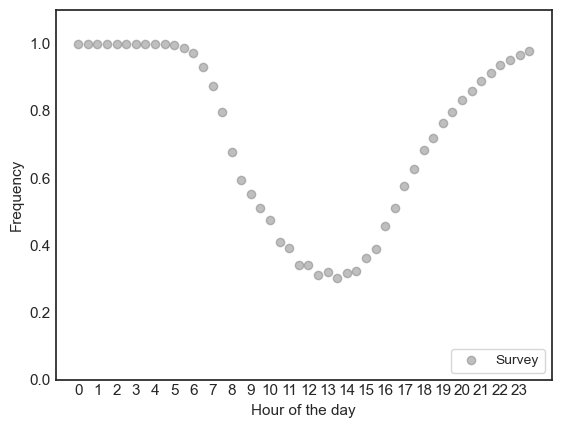

In [94]:
plt.scatter(df_tempo_home['half_hour'], df_tempo_home['freq'], label='Survey', color="grey", alpha=0.5)
plt.xlabel('Hour of the day', fontsize=11)
plt.ylabel('Frequency', fontsize=11)


x_labels = range(0, 24)  # Generate labels from 1 to 24
x_ticks = range(0, 48, 2)  # Position the labels every other data point
plt.ylim(0, 1.1)
plt.xticks(x_ticks, x_labels, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, frameon=True, loc='lower right')
plt.savefig('figures/temporal_visitation_pattern'+urban_density_level+'.png', dpi=300, bbox_inches="tight")
plt.show()